In [1]:
from itertools import product, chain
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import sleep
from PIL import Image as Imag
import pyautogui
import pandas as pd
from copy import deepcopy

In [2]:
# Legal moves list
candy_all=['blue', 'red', 'green', 'violett', 'orange']

In [3]:
def closeButtonLookup():
    '''Looks for close button and presses it returns False if close button is not found, else - True'''
    if bool(pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7))==True:
        x, y = pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7)
        pyautogui.click(x/2, y/2, duration=0.5, button='right')
        print('OK,I am out of here!')
        return True
    return False

In [4]:
class GameState():
    
    '''Game state, board = dataframe, 'frm' and 'at' = lists of row/colum values of origin and current position'''
    
    def __init__(self,  board, parent=None, frm=None, at=None):
        self.board = board
        self.parent = parent
        self.frm = frm
        self.at = at
        self.score = 0
        self.double = False
        self.super = False
        self.matches_vert = list()
        self.matches_horiz = list()
        self.children = list()

In [5]:
class Match():
    
    '''Match contains info on size, position and type of candy'''
    
    def __init__(self, typ, pos):
        self.size = pos.shape[0]
        self.pos = pos
        self.typ = typ       

In [6]:
def find_match(selected): 
    
    '''Takes Series as an input, returns index of a match3 in the series if there is, else: False'''
    
    match=[i for i in selected.index]
    diff = [1]+[i-j for j,i in zip(match[:-1], match[1:])]
    diff = np.absolute(np.array(diff)) 
    mask = diff == 1
    if selected[mask].size>=3:
        return list(selected[mask].index)
    return 

In [7]:
def move_to(global_board, fr, to):

    '''Takes a Dataframe, and two lists of row/col values, swaps values in specified cells. 
        Outputs resulting Data frame '''
    local_board=global_board.copy()
    local_board.loc[fr[0], fr[1]], local_board.loc[to[0], to[1]] = local_board.loc[to[0], to[1]], local_board.loc[fr[0], fr[1]]

    return local_board

In [8]:
def generate_children(global_board, pos):

    '''Generate gamestates from valid moves from a given tile, pos=list of row/col values.
    Return list of gamestates.'''

    positions = np.array(pos)
    directions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    moves = np.add(positions, directions)

    # Filter the values outside of the local_board
    moves = moves[(0<=moves[:,0]) & (moves[:,0]< board_w)]
    moves = moves[(0<=moves[:,1]) & (moves[:,1]< board_h)]

    # Filter the legal_tiles moves and save them in a children nodes attribute
    children=[]
    for move in moves:
        if tuple(move) in legal_tiles:
            local_board = move_to(global_board, pos, move)
#             display(local_board)
            m = GameState(local_board, None, frm=pos, at=move)
#             print(id(m.board))
            children.append(m)

    return children

## Create board

#### Get input for board height and width.

In [9]:
# board_w = int(input('Borad width is:  '))
board_w = 5

In [10]:
# board_h = int(input('Borad width is: '))
board_h = 5

In [104]:
board = pd.DataFrame('0', index=range(board_h), columns=range(board_w))
Root = GameState(board.copy()) 

In [105]:
def select_type(typ, board, ind=board.index, col=board.columns):

    '''Select all instances of a given type in a Series = board.iloc[index, column] 
    where board is Pandas DataFrame. When calling the function one of the kwargs MUST be given in a call'''

    selected = board.loc[ind,col][board.loc[ind,col]==typ]
    if selected.size>=3:
        return selected

    return pd.Series(dtype='object')

In [106]:
all_tiles = list(product(range(5),range(5)))
# all_tiles

#### Add some candy manually for testing purpouse

In [107]:
Root.board.loc[1,[1,2]]='red'
Root.board.loc[2,[2,3]]='blue'
Root.board.loc[[0,2,3],4]='red'
Root.board.loc[1,1]='blue'
Root.board.loc[[2,3],1]='orange'
Root.board.loc[1,[2,3]]='orange'
Root.board.loc[0,1]='red'
Root.board.loc[1,4]='blue'
Root.board.loc[3,2]='blue'
# Root.board.loc[2,0], Root.board.loc[2,1]=Root.board.loc[2,1],Root.board.loc[2,0]

In [108]:
legal_tiles = [tile for tile in all_tiles if Root.board.iloc[tile[0], tile[1]] in candy_all]
# legal_tiles

In [109]:
Root.board

,0,1,2,3,4
0,0,red,0,0,red
1,0,blue,orange,orange,blue
2,0,orange,blue,blue,red
3,0,orange,blue,0,red
4,0,0,0,0,0


## Look for the matches

In [110]:
candidates = list()

In [111]:
for tile in legal_tiles:
#     print(tile)
#     display(generate_children(Root.board.copy(), tile)[0].board)
    candidates.extend(generate_children(Root.board.copy(), tile))

In [112]:
# candidates

### Look for matches in the resulting boards.

In [113]:
for candidate in candidates:
    # Column-wise
    # Get types of the match to look for.
    types=[]
    types.append(candidate.board.iloc[candidate.frm[0], candidate.frm[1]])
    types.append(candidate.board.iloc[candidate.at[0], candidate.at[1]])
    for typ in types:

        # Search the column for the values of the given type
        res_vert = {i : select_type(typ, candidate.board, col=i) for i in candidate.board.columns 
                    if select_type(typ, candidate.board, col=i).any()}

        # Now look for actual matches in the result of the search
        for key, val in res_vert.items():
                        match = find_match(val)
                        if match:
                            candidate.matches_vert.append( Match( val.all(), candidate.board.loc[match,key] ))
        # And row-wise
        res_horiz = {i : select_type(typ, candidate.board, ind=i) for i in candidate.board.index 
                     if select_type(typ, candidate.board, ind=i).any()}

        for key, val in res_horiz.items():
                        match = find_match(val)
                        if match:
                            candidate.matches_horiz.append( Match( val.all(), candidate.board.loc[key, match] ))

### Prune the children. Keep boards with matches, delete the rest.

In [116]:
# Choose candidates that have vertical matches:
vert_cands = [cand for cand in candidates if any(cand.matches_vert)]

In [117]:
# Choose candidates that have horizontal matches:
horiz_cands = [cand for cand in candidates if any(cand.matches_horiz)]

### Evaluate children

In [118]:
selected = []

In [ ]:
# Look for double matches as they are likely to indicate super matches
# Select cadidates that have matches in both horiz and vert, both matches are same color.

In [119]:
for gamestate in filter(lambda x: x in horiz_cands, vert_cands):
#     display(gamestate.board)
    if any([i.typ==j.typ for i in gamestate.matches_vert for j in gamestate.matches_horiz]):
        gamestate.super=True
    else:
        gamestate.double=True
    selected.append(gamestate)    

In [120]:
# Sum of all matches sizes in the GameState
def sum_score(instance):
    s = sum([match.size for match in instance.matches_horiz]) + sum(match.size for match in instance.matches_vert)   
    return s

In [122]:
main_candidate_horiz = max(horiz_cands, key=sum_score)
if any([match.size>3 for match in main_candidate_horiz.matches_horiz]):
    main_candidate_horiz.super = True

In [123]:
main_candidate_vert = max(vert_cands, key=sum_score)
if any([match.size>3 for match in main_candidate_vert.matches_vert]):
    main_candidate_vert.super = True

In [124]:
main_candidate_horiz.score = sum_score(main_candidate_horiz)

In [125]:
main_candidate_vert.score = sum_score(main_candidate_vert)

In [126]:
selected.extend([main_candidate_horiz, main_candidate_vert])

In [127]:
best = max(selected, key = lambda x: x.score)

In [269]:
best.board

,0,1,2,3,4
0,0,red,0,0,red
1,0,orange,orange,orange,blue
2,0,blue,blue,blue,red
3,0,orange,blue,0,red
4,0,0,0,0,0


In [ ]:
# screen size
pyautogui.size().height

In [ ]:
tile_w = 500/7
tile_h = 524/8

In [ ]:
offset_x = tile_w/2
offset_y = tile_h/2

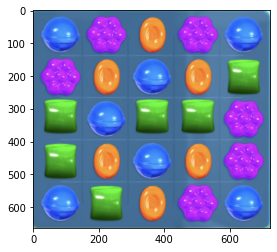

In [130]:
image = Imag.open("Images/game_board.png")
image_array = np.array(image)
imgplot = plt.imshow(image_array)

In [211]:
display(round(image_array.shape[0]/5), round(image_array.shape[1]/5))

133

145

In [202]:
green = image_array[133*2:133*3, 15:145] 
violet = image_array[133:133*2,15:145]
blue = image_array[:133, :145]
orange = image_array[:133, 145*2:145*3]

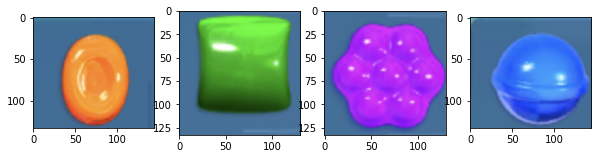

In [197]:
fig = plt.figure(figsize=(10, 7))
rows =1
columns =4
count=0
for im in [orange, green, violet, blue]:
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(im)   

In [ ]:
# Save images
for im in for im in [orange, green, violet, blue]:
    matplotlib.image.imsave(f'candy_{im}.png')

In [205]:
print(blue.shape)
a = np.mean(blue, axis=1)
b = np.ones(133)
blue_mean = np.matmul(a.T,b)/133

(133, 145, 4)


In [199]:
# Get mean RGB values
c = np.mean(orange, axis=1)
orange_mean = np.matmul(c.T,b)/133

In [201]:
d = np.mean(violet, axis=1)
violet_mean = np.matmul(d.T,b)/133

In [204]:
e = np.mean(green, axis=1)
green_mean = np.matmul(e.T,b)/133

In [208]:
display(green_mean - blue_mean)

array([ 11.25116172,  26.83221116, -98.35942043,   0.        ])

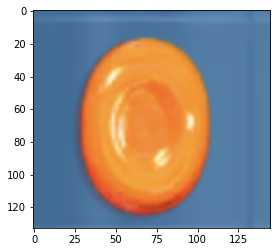

In [219]:
sample1 = image_array[133:133*2, 145*3:145*4]
plt.imshow(sample1)

In [222]:
def pix_avg(pix_array):
    x = np.mean(pix_array, axis=1)
    y = np.ones(133)
    return np.matmul(x.T,y)/133

In [223]:
pix_avg(sample1)

array([133.94980555, 126.79533316, 123.41840809, 255.        ])

In [233]:
candy_rgb = pd.DataFrame([green_mean,blue_mean,violet_mean, orange_mean], index =['green','blue','violet','orange'])

In [263]:
diff = candy_rgb - pix_avg(sample1)
diff

,0,1,2,3
green,-56.530430,14.429826,-27.891803,0.0
blue,-67.781592,-12.402385,70.467617,0.0
violet,-2.414062,-55.034951,82.091193,0.0
orange,-6.855276,-6.378118,-6.362873,0.0


In [260]:
error = np.matmul(np.abs(candy_rgb.to_numpy()-pix_avg(sample1).T), np.ones(4))

In [262]:
np.argmin(error)

3

In [268]:
candy_rgb.index[3]

'orange'